# Data Augmentation Model

- Train: 75Agree_train
- Test: 75Agree_test

# TODO

- missing cv for hyp tunning

- organize better the code

- data augmentation hyperparameters (tune?) and get better examples

In [ ]:
import nltk
import spacy
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedKFold
from transformers import MarianMTModel, MarianTokenizer
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

#spacy.cli.download("en_core_web_sm")
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /Users/hugover/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Step 1: Read the original data

In [9]:
# load the training and test datasets
df_train = pd.read_csv('data/75Agree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')

# label encoders
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# label encoding
df_train["label"] = df_train["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_7449/918004758.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)


label
0    336
1    336
2    336
Name: count, dtype: int64

### Step 2: Create the data augmentation pipeline

In [10]:
class AugmentedTextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128,
                 p_back=0.2, p_syn=0.3, p_ner=0.2, p_none=0.3):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.p_back = p_back
        self.p_syn = p_syn
        self.p_ner = p_ner
        self.p_none = p_none

        self.nlp = spacy.load("en_core_web_sm")

        en_de_model_name = "Helsinki-NLP/opus-mt-en-de"
        de_en_model_name = "Helsinki-NLP/opus-mt-de-en"
        self.en_de_tok = MarianTokenizer.from_pretrained(en_de_model_name)
        self.de_en_tok = MarianTokenizer.from_pretrained(de_en_model_name)
        self.en_de_mod = MarianMTModel.from_pretrained(en_de_model_name)
        self.de_en_mod = MarianMTModel.from_pretrained(de_en_model_name)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.loc[idx, 'sentence']
        label = self.df.loc[idx, 'label']

        # Randomly apply augmentation techniques based on probabilities
        if not random.random() < self.p_none:
            if random.random() < self.p_back:
                text = self.back_translate(text) or text
            if random.random() < self.p_syn:
                text = self.synonym_replace(text) or text
            if random.random() < self.p_ner:
                text = self.ner_replace(text) or text

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze() for k, v in encoding.items()}
        item["labels"] = torch.tensor(label)
        return item

    def back_translate(self, text):
        try:
            de = self.translate(text, self.en_de_tok, self.en_de_mod)
            return self.translate(de, self.de_en_tok, self.de_en_mod)
        except:
            return None

    def translate(self, text, tokenizer, model):
        batch = tokenizer([text], return_tensors="pt", padding=True, truncation=True)
        gen = model.generate(**batch)
        return tokenizer.decode(gen[0], skip_special_tokens=True)

    def get_synonyms(self, word):
        syns = set()
        for syn in wordnet.synsets(word):
            for l in syn.lemmas():
                w = l.name().replace('_', ' ')
                if w.lower() != word.lower():
                    syns.add(w)
        return list(syns)

    def synonym_replace(self, text, p=0.2):
        words = text.split()
        out = []
        for word in words:
            if random.random() < p:
                syns = self.get_synonyms(word)
                if syns:
                    out.append(random.choice(syns))
                    continue
            out.append(word)
        return ' '.join(out)

    def ner_replace(self, text):
        doc = self.nlp(text)
        template, pool = self.extract_template(doc)
        if not pool:
            return None
        return self.fill_template(template, pool)

    def extract_template(self, doc):
        entity_pool = {}
        template = doc.text
        offsets = []
        for ent in doc.ents:
            if ent.label_ in ["ORG", "DATE", "EVENT"]:
                tag = f"<{ent.label_}>"
                offsets.append((ent.start_char, ent.end_char, tag, ent.text, ent.label_))
                if ent.label_ not in entity_pool:
                    entity_pool[ent.label_] = set()
                entity_pool[ent.label_].add(ent.text)

        offsets.sort()
        new_text = ""
        last = 0
        for start, end, tag, _, _ in offsets:
            new_text += template[last:start] + tag
            last = end
        new_text += template[last:]
        return new_text, entity_pool

    def fill_template(self, template, entity_pool):
        out = template
        for label, values in entity_pool.items():
            tag = f"<{label}>"
            if tag in out and values:
                out = out.replace(tag, random.choice(list(values)))
        return out

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

dataset = AugmentedTextDataset(df_train, tokenizer, p_none=0)

for i in range(5):
    original = df_train.loc[i, 'sentence']
    augmented = dataset[i]
    decoded = tokenizer.decode(augmented['input_ids'], skip_special_tokens=True)
    print(f"{original}\n{decoded}\n")


It generated an operating loss of EUR 96.3 mn , down from a profit of EUR 43.9 mn .
it generated an operating loss of eur 96. 3 million from a profit of eur 43. 9 million.

In the building and home improvement trade , sales decreased by 22.5 % to EUR 201.4 mn .
in the progress and diy trade, gross sales lessen by 22. 5 % to eur 201. 4 million.

In a media advisory , the NTSB said that after subsequent testing , `` the train detection system intermittently failed . ''
in a culture medium advisory, the ntsb said that after subsequent test, ` ` the train sleuthing system intermittently failed.''

Qualcomm estimated a first-quarter profit between 46 and 50 cents a share , excluding certain items , below the analyst estimate of 61 cents a share .
qualcomm estimated a first - quarter profit between 46 and 50 cents a share, excluding certain items, below the analyst estimate of 61 cents a share.

Net sales for the financial year 2006 are expected to amount to about EUR20m and the operating re

In [ ]:
# dataset preparation for huggingface transformers
train_dataset = AugmentedTextDataset(df_train, tokenizer, p_none=0.1)
test_dataset = AugmentedTextDataset(df_test, tokenizer, p_none=1)

# the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    num_train_epochs=2,
    learning_rate=0.0001,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=25,
    logging_strategy="steps",
    logging_steps=25,
    report_to=None,
    dataloader_pin_memory=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=1,
    save_steps=500,
    output_dir="./results",
)

# train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_7449/3484501474.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
25,0.884200,0.837949
50,0.479600,0.297096
75,0.383300,0.330768
100,0.247200,0.268735
125,0.317700,0.260775


TrainOutput(global_step=126, training_loss=0.4620668107555026, metrics={'train_runtime': 727.4301, 'train_samples_per_second': 2.771, 'train_steps_per_second': 0.173, 'total_flos': 132609162534912.0, 'train_loss': 0.4620668107555026, 'epoch': 2.0})

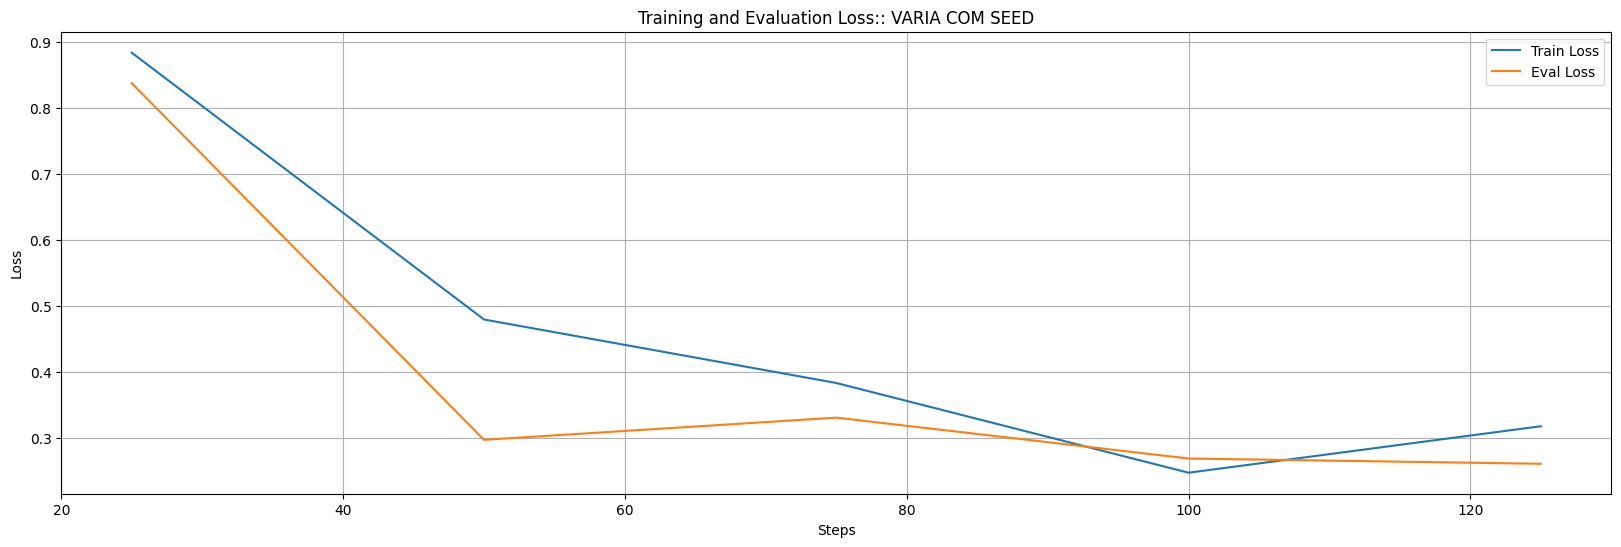

In [13]:
# get training and evaluation loss history
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
train_steps = [x["step"] for x in log_history if "loss" in x]

plt.figure(figsize=(20, 6))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss:: VARIA COM SEED")
plt.legend()
plt.grid(True)
plt.show()


=== Classification Report (Train) ===
              precision    recall  f1-score   support

    negative       0.98      0.97      0.97       336
     neutral       0.98      0.96      0.97       336
    positive       0.95      0.97      0.96       336

    accuracy                           0.97      1008
   macro avg       0.97      0.97      0.97      1008
weighted avg       0.97      0.97      0.97      1008



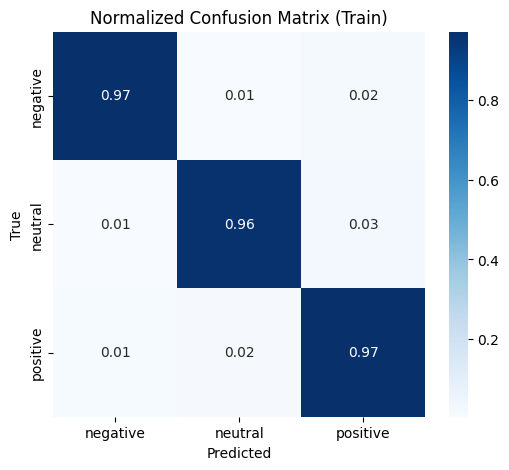


=== Classification Report (Test) ===
              precision    recall  f1-score   support

    negative       0.86      0.95      0.90        84
     neutral       0.98      0.90      0.94       429
    positive       0.82      0.93      0.87       178

    accuracy                           0.92       691
   macro avg       0.89      0.93      0.91       691
weighted avg       0.92      0.92      0.92       691



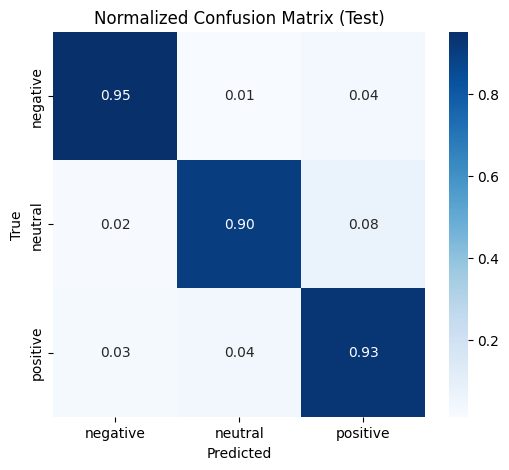

In [14]:
train_dataset = AugmentedTextDataset(df_train, tokenizer, p_none=1)
test_dataset = AugmentedTextDataset(df_test, tokenizer, p_none=1)

def evaluate_dataset(dataset, split_name):
    output = trainer.predict(dataset)
    preds = np.argmax(output.predictions, axis=1)
    y_true = output.label_ids

    print(f"\n=== Classification Report ({split_name}) ===")
    print(classification_report(y_true, preds, target_names=["negative", "neutral", "positive"]))

    cm = confusion_matrix(y_true, preds, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Normalized Confusion Matrix ({split_name})")
    plt.show()

# evaluate the model on the training and test datasets
evaluate_dataset(train_dataset, "Train")
evaluate_dataset(test_dataset, "Test")